In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [31]:
df = pd.read_csv('../Data/subredditdatacleaned.csv')

In [32]:
df.head(2)

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,Do the crazy customers realize that they becom...,removed_asdf_fix,0,1636729943
1,1,Store music volume controls,"My most recent job, and hopefully last, in ret...",0,1636729678


In [33]:
df = df.drop(columns=['Unnamed: 0'])

# TalesFromRetail: 0, TalesFromTechSupport: 1

In [34]:
df.head()

,title,selftext,subreddit,created_utc
0,Do the crazy customers realize that they becom...,removed_asdf_fix,0,1636729943
1,Store music volume controls,"My most recent job, and hopefully last, in ret...",0,1636729678
2,Ways of Rejection,I'll just hop right into it as there's no poin...,0,1636725427
3,JUST TELL US WHAT IT'S USED FOR!,removed_asdf_fix,0,1636694714
4,You've got to go collect stray shopping carts ...,removed_asdf_fix,0,1636679308


In [35]:
df['subreddit'].value_counts(normalize=True)

1    0.501878
0    0.498122
Name: subreddit, dtype: float64

### Our baseline accuracy rate will be 50.18%, based of distribution above

# Setting our X,y and creating our Train/Test split

In [36]:
df['subreddit'] = df['subreddit'].map({0: 'TalesFromRetail', 1: 'TalesFromTechSupport'})

In [37]:
df['all_words'] = df['title'] + df['selftext']

In [38]:
features = ['title', 'selftext'] 
X = df['all_words']
y = df['subreddit']

In [39]:
y.value_counts()

TalesFromTechSupport    1470
TalesFromRetail         1459
Name: subreddit, dtype: int64

In [40]:
X.shape

(2929,)

In [41]:
y.shape

(2929,)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
X_train.shape

(2196,)

In [44]:
y_train.shape

(2196,)

In [45]:
X_test.shape

(733,)

In [46]:
y_test.shape

(733,)

In [47]:
y_train.value_counts()

TalesFromTechSupport    1105
TalesFromRetail         1091
Name: subreddit, dtype: int64

# Model 1 Pipe/GS

In [48]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('removed_asdf_fix') # adding stop word
# Inspiration https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist

In [49]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [50]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', LogisticRegression(max_iter=1_000))
])

In [83]:
params = {
    'cvec__stop_words': ['english', stopwords],
    'cvec__min_df': [3, 4],
    'cvec__max_df':[.3],
    'cvec__binary': [True, False],
    'cvec__ngram_range': [(1,2)],
    #'model__penalty': ['l1', 'l2'],# <- Will error out due to non scale
    #'model__solver': ['lbfgs', 'liblinear'] 
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8601905156347069


{'cvec__binary': True,
 'cvec__max_df': 0.3,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

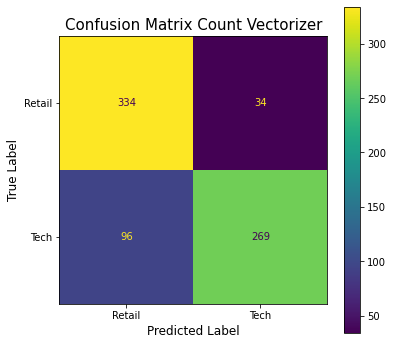

In [98]:
# inspiration https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Retail', 'Tech'], ax=ax)
plt.title('Confusion Matrix Count Vectorizer', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12);
#plt.savefig('../Visuals/matrixCVectorizer.png', bbox_inches='tight')

In [87]:
tn1, fp1, fn1, tp1 = 334, 34, 96, 269

### Accuracy

In [88]:
(tn1 + tp1) / (tn1 +tp1 + fp1 + fn1)

0.8226466575716235

### Specificity

In [90]:
tn1 / (tn1 + fp1)

0.907608695652174

### Sensitivity

In [91]:
tp1 / (tp1 + fn1)

0.736986301369863

### Precision

In [92]:
tp1 / (tp1 + fp1)

0.8877887788778878

# Model 2 Pipe/GS

In [58]:
pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1_000))
])

In [84]:
params2 = {
    'tfidf__stop_words': ['english', stopwords],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__max_df':[.29, .3, .31],
    'tfidf__binary': [True, False],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'model__solver': ['lbfgs', 'liblinear']
}
gs1 = GridSearchCV(pipe2, param_grid=params2)
gs1.fit(X_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.8820511493062746


{'model__solver': 'liblinear',
 'tfidf__binary': True,
 'tfidf__max_df': 0.3,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

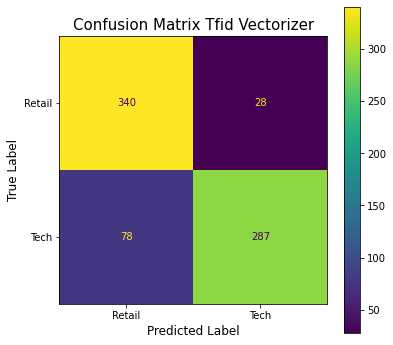

In [99]:
# inspiration https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(gs1, X_test, y_test, display_labels=['Retail', 'Tech'], cmap='viridis', ax=ax)
plt.title('Confusion Matrix Tfid Vectorizer', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12);
plt.savefig('../Visuals/matrixTfidVectorizer.png', bbox_inches='tight')

In [93]:
tn2, fp2, fn2, tp2 = 340, 28, 78, 287

### Accuracy

In [94]:
(tn2 + tp2) / (tn2 +tp2 + fp2 + fn2)

0.8553888130968622

### Specificity

In [95]:
tn2 / (tn2 + fp2)

0.9239130434782609

### Sensitivity

In [96]:
tp2 / (tp2 + fn2)

0.7863013698630137

### Precision

In [97]:
tp2 / (tp2 + fp2)

0.9111111111111111